#Import

In [91]:
%pip install -q web3

Note: you may need to restart the kernel to use updated packages.


In [1]:
# from web3 import Web3
import pandas as pd
pd.set_option('display.max_rows', 100)
from tqdm import tqdm
import ast #eval() to interpret code
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
tqdm.pandas()
import time
import warnings
warnings.filterwarnings('ignore')
from pandas import Timestamp

#Read File from Preprocessing01

In [2]:
decode = pd.read_csv('Decode_Jul_2023.csv')
decode.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
print(decode.shape)

(4466880, 5)


In [5]:
def clean_args(df):
  ''' will return column 'args' in table with dictionary without special characters'''
  df['args'] = df['args'].apply(lambda x: x.replace("b'", "'"))
  df['args'] = df['args'].apply(lambda x: x.replace("\\x00", ""))
  df['args'] = df['args'].apply(lambda x: x.replace("\'", "\""))
  return df

In [6]:
#first clean args
df = clean_args(decode)
df

,timestamp,order_trx,transaction_hash,fn_name,args
0,2019-11-13 19:16:32 UTC,0,0xa39edcdeb7310150d7be44b8da94e5043d1cf8600d59...,rely,"{""usr"": ""0xbaa65281c2FA2baAcb2cb550BA051525A48..."
1,2019-11-13 19:16:32 UTC,1,0xa39edcdeb7310150d7be44b8da94e5043d1cf8600d59...,deny,"{""usr"": ""0x403689148fA98a5a6fDcC0b984914Ae968d..."
2,2019-11-13 19:16:32 UTC,2,0xa39edcdeb7310150d7be44b8da94e5043d1cf8600d59...,rely,"{""usr"": ""0x65C79fcB50Ca1594B025960e539eD7A9a6D..."
3,2019-11-13 19:18:41 UTC,3,0xaac1fe54d617a879bb05bec28b1dd4159f3ad1ba1e67...,rely,"{""usr"": ""0x19c0976f590D67707E62397C87829d896Dc..."
4,2019-11-13 19:18:41 UTC,4,0xaac1fe54d617a879bb05bec28b1dd4159f3ad1ba1e67...,rely,"{""usr"": ""0x197E90f9FAD81970bA7976f33CbD77088E5..."
...,...,...,...,...,...
4466875,2023-07-31 23:49:35 UTC,4466875,0x26c9d1e2d7f72436488525cb124c9d1ba9a4e3e9a81a...,frob,"{""i"": ""PSM-USDC-A"", ""u"": ""0x89B78CfA322F6C5dE0..."
4466876,2023-07-31 23:49:35 UTC,4466876,0x26c9d1e2d7f72436488525cb124c9d1ba9a4e3e9a81a...,move,"{""src"": ""0x89B78CfA322F6C5dE0aBcEecab66Aee4539..."
4466877,2023-07-31 23:49:35 UTC,4466877,0x26c9d1e2d7f72436488525cb124c9d1ba9a4e3e9a81a...,move,"{""src"": ""0x89B78CfA322F6C5dE0aBcEecab66Aee4539..."
4466878,2023-07-31 23:55:59 UTC,4466878,0xe799722397920e4c9a7d5267bec2650ea8846220880d...,file,"{""ilk"": ""UNIV2DAIUSDC-A"", ""what"": ""spot"", ""dat..."


In [8]:
#diff data as of Jul23 - data as of Mar23
print(f' diff data as of Jul23 - data as of Mar23: {4466880 - 4328784} rows')

 diff data as of Jul23 - data as of Mar23: 138096 rows


Filter functions

In [9]:
df = df.loc[
    (df['fn_name'] == 'grab')
    |
    (df['fn_name'] == 'frob')
    |
    (df['fn_name'] == 'fold')
    |
    (df['fn_name'] == 'flux')
    |
    (df['fn_name'] == 'move') 
    |
    (df['fn_name'] == 'fork')
]
df.reset_index(drop = True, inplace=True)

VAT class modifies from Grigorii Melnikov(Modified code)

In [14]:
class Vat(object):
    index = ['fn_name', 'ilk', 'usr', 'src', 'state']

    def __init__(self):
        pass

    def get_data(self, fn_name, ilk, usr, src=None):
        data = [ fn_name, ilk, usr, src, None]
        return data

    def parse_init(self, fn_args): #filter out didn't use it
        ilk = fn_args['ilk']
        data = [ 'init', ilk, None, None, None ]
        return pd.Series(data=data, index=Vat.index)

    def parse_frob(self, fn_args):
        ilk = fn_args['i']
        u = fn_args['u'] #it'll be vault(usr)
        v = fn_args['v']
        data = self.get_data('frob', ilk, u, v)
        return pd.Series(data=data, index=Vat.index)

    def parse_grab(self, fn_args):
        ilk = fn_args['i']
        u = fn_args['u'] #usr
        data = self.get_data('grab', ilk, u)
        return pd.Series(data=data, index=Vat.index)

    def parse_slip(self, fn_args):
        ilk = fn_args['ilk'] #didn't use it
        usr = fn_args['usr'] #it's not vault
        wad = fn_args['wad']
        data = self.get_data('slip', ilk, usr)
        return pd.Series(data=data, index=Vat.index)

    def parse_fold(self, fn_args):
        ilk = fn_args['i']
        rate = fn_args['rate']
        data = [ 'fold', ilk, None, None, { "rate": rate } ]
        return pd.Series(data=data, index=Vat.index)

    def parse_file(self, fn_args):
        # print (len(fn_args))
        ilk = fn_args.get('ilk', None)
        ilk = ilk if ilk else None 
        data = fn_args['data']
        what = fn_args['what'].decode('utf-8')[:4]
        data = [ 'file', ilk, None, None, {"data": data,"what": what} ]
        return pd.Series(data=data, index=Vat.index)

    def parse_fork_I(self, fn_args): #transfer out -dart, -dink
        ilk = fn_args['ilk']
        src = fn_args['src']
        dst = fn_args['dst']
        data = self.get_data('fork', ilk, src, dst)
        return pd.Series(data=data, index=Vat.index)

    def parse_fork_II(self, fn_args): #transfer in +dart, +dink
        ilk = fn_args['ilk']
        src = fn_args['src']
        dst = fn_args['dst']
        data = self.get_data('fork', ilk, dst, src )
        return pd.Series(data=data, index=Vat.index)

    def parse_flux(self, fn_args):
        ilk = fn_args['ilk']
        dst = fn_args['dst'] #some trx dst is not vault!!
        src = fn_args['src']
        data = self.get_data('flux', ilk, dst, src)
        return pd.Series(data=data, index=Vat.index)

    def parse_move(self, fn_args):
        ilk = None
        address = ['0x9759A6Ac90977b93B58547b4A71c78317f391A28',
                   '0x4729064efA9Fcf832C89191053Ec62c3eF7E19e0',
                   '0x8f4cEF8C3335525d85f3Ba5299842010Fc9F7869',
                   '0xA4C11215a7c1FF6897A7eF8141F816B67ef73372',
                   '0x402F9314D9337A34112FE3484BD87E06095036a3',
                   '0x78F2c2AF65126834c51822F56Be0d7469D7A523E']

        src = fn_args['src']
        dst = fn_args['dst']
        if src not in address:
          usr = src #vault
        else:
          usr = dst
        data = self.get_data('move', ilk, usr, dst)
        return pd.Series(data=data, index=Vat.index)

##Get vaults function from Grigorii Melnikov(modified code)

In [15]:
def get_vault(df, vat):
  '''
  Define usrs' id for each row of transaction

  Parameters:
    df - table of decoding raw data from Big Query
    vat - class using for parse data

  Return: Table with usrs' id 
  '''
  data = []
  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    fn_name    = row['fn_name']
    time_stamp = row['timestamp']
    txn_hash   = row['transaction_hash']
    obj        = row['args']
    res        = json.loads(obj)

    series = None
    dart = res.get('dart', None)
    dink = res.get('dink', None)
    rad = res.get('rad', None)

    tab = pd.Series([time_stamp, txn_hash], index=['timestamp', 'transaction_hash'])
    ddr = pd.Series([dart, dink, rad], index=['dart', 'dink', 'rad'])

    if fn_name == 'grab':
      series = vat.parse_grab(res)

    elif fn_name == 'frob':
      series = vat.parse_frob(res)

    elif fn_name == 'fold':
      series = vat.parse_fold(res)

    elif fn_name == 'flux':
      series = vat.parse_flux(res)

    elif fn_name == 'move':
      series = vat.parse_move(res)

    elif fn_name == 'fork':
      ddr = pd.Series([-dart, -dink, None], index=['dart', 'dink', 'rad'])
      series = vat.parse_fork_I(res) ##transfer out -dart, -dink
      series = series.append(ddr)
      table = tab.append(series)
      data.append(table)

      tab = pd.Series([time_stamp, txn_hash], index=['timestamp', 'transaction_hash'])
      ddr = pd.Series([dart, dink, None], index=['dart', 'dink', 'rad'])
      series = vat.parse_fork_II(res) #transfer in +dart, +dink
    
    series = series.append(ddr)
    table = tab.append(series)
    data.append(table)

  cols = ['timestamp', 'transaction_hash', 'fn_name', 'ilk', 'usr', 'src', 'state', 'dart', 'dink', 'rad']
  table = pd.DataFrame(data=data, columns=cols)
  return table

In [16]:
vat = Vat()
vau = get_vault(df, vat)

100%|██████████| 2635567/2635567 [25:18<00:00, 1735.14it/s] 


In [17]:
vau.to_csv('tab_vaults.csv')

Get Rad values from 'move' function and remove 'move' function

In [21]:
def get_rad_(df):
    '''
    To prepare data before running 'get_operations' function
    From the structure of data 'generate dai' in case A and 'payback dai' in case B

    Pre-requitesite:
    Case A: data in row of 'frob' function with 'dart' > 0 there'll be 'move' after transaction
    Case B: data in row of 'frob' function with 'dart' < 0 there'll be 'move' before transaction

    Return:
    Table which 'frob' function contains 'rad' value and remove transaction in 'move' function
    '''

    def process_user_group(tab):
        tab['rad'] = np.where((tab['fn_name'] == 'frob') & (tab['dart'] > 0), tab['rad'].shift(-1),
                              np.where((tab['fn_name'] == 'frob') & (tab['dart'] < 0), tab['rad'].shift(1),
                                       tab['rad']))

        fn_name_mask = tab['fn_name'] != 'move'
        return tab[fn_name_mask]

    cols = ['timestamp', 'transaction_hash', 'fn_name', 'ilk', 'usr', 'src', 'state', 'dart', 'dink', 'rad']

    data = []
    table = pd.DataFrame(data=data, columns=cols)
    grouped = df.groupby('usr')

    for usr, user_group in tqdm(grouped):
        
        user_group_processed = process_user_group(user_group.copy())
        table = table.append(user_group_processed, ignore_index=True)

    return table

In [24]:
rad = get_rad_(vau)

100%|██████████| 62229/62229 [49:38<00:00, 20.89it/s]  


In [25]:
rad.to_csv('rad_vaults.csv')

#Define operations

In [28]:
def get_operations(df):
  '''
  This function will define user-actions for each row of transactions
  
  Pre-requisite:
    table with function frob/fork/grab
    frob - is about generate dai/payback dai or lock assets/unlock assets
    fork - is about transfer assets and debt between vaults
    grab - is about liquidation process

  Notes:
    dink - collateral assets
    dart - dai debt in usd exchange
    rad  - dai issued from platform 

  Return:
    Table with actions  - lock assets
                        - unlock assets
                        - generate dai
                        - payback dai
                        - transfer in
                        - transfer out
                        - liquidate 
  '''
  cols = ['usr', 'ilk', 'transaction_hash', 'timestamp', 'user_action', 'lock_collateral', 'dai', 'dai(in exchange)']
  data = []
  table = pd.DataFrame(data=data, columns=cols)
  df['dart'] = df['dart'].apply(lambda x: float(x)/1e18)
  df['dink'] = df['dink'].apply(lambda x: float(x)/1e18)
  df['rad'] = df['rad'].apply(lambda x: float(x)/1e45)

  for idx, row in df.iterrows():
    usr = row['usr']
    txn = row['transaction_hash']
    time = row['timestamp']
    func = row['fn_name']
    ilk = row['ilk']
    dart = row['dart']
    dink = row['dink']
    rad = row['rad']

#--------------------  --------- Check frob ------------------------------------
    if func == 'frob':
      if dink > 0 and dart > 0:
        oper = 'lock asset'
        data = [usr, ilk, txn, time, oper, dink, 0, 0]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

        oper = 'generate dai'
        data = [usr, ilk, txn, time, oper, 0, rad, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

      if dink > 0 and dart == 0:
        oper = 'lock asset'
        data = [usr, ilk, txn, time, oper, dink, 0, 0]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)
#-------------------------------------------------------------------------------
      if dink < 0 and dart < 0:
        oper = 'payback dai'
        data = [usr, ilk, txn, time, oper, 0, -rad, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

        oper = 'unlock asset'
        data = [usr, ilk, txn, time, oper, dink, 0, 0]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

      if dink < 0 and dart == 0:
        oper = 'unlock asset'
        data = [usr, ilk, txn, time, oper, dink, 0, 0]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)
#-------------------------------------------------------------------------------
      if dink == 0 and dart > 0:
        oper = 'generate dai'
        data = [usr, ilk, txn, time, oper, 0, rad, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

      if dink == 0 and dart < 0:
        oper = 'payback dai'
        data = [usr, ilk, txn, time, oper, 0, -rad, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

#--------------------  --------- Check fork ------------------------------------
    if func == 'fork':
      if dink > 0 or dart > 0:
        oper = 'transfer in'
        data = [usr, ilk, txn, time, oper, dink, 0, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

      if dink < 0 or dart < 0:
        oper = 'transfer out'
        data = [usr, ilk, txn, time, oper, dink, 0, dart]
        table = table.append(pd.Series(data, index=cols), ignore_index=True)

#--------------------  --------- Check grab ------------------------------------
    if func == 'grab':
      oper = 'liquidate'
      data = [usr, ilk, txn, time, oper, dink, 0, dart]
      table = table.append(pd.Series(data, index=cols), ignore_index=True)

  return table

In [29]:
def get_oper(df):
  '''
  This function is to perform data after define operation in dataframe format
  and to work with 'get_operations' function
  '''
  all_usr = list(df['usr'].unique())
  cols = ['usr', 'ilk', 'transaction_hash', 'timestamp', 'user_action', 'lock_collateral', 'dai', 'dai(in exchange)']
  data = []
  table = pd.DataFrame(data=data, columns=cols)

  for usr in tqdm(all_usr):

    tab = df[df['usr'] == usr]
    res = get_operations(tab)
    table = table.append(res)

  table = table.reset_index(drop=True)
  
  return table

In [30]:
operations = get_oper(rad)
operations

100%|██████████| 49481/49481 [3:10:34<00:00,  4.33it/s]      


,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,dai(in exchange)
0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00 UTC,lock asset,90.5,0,0
1,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00 UTC,generate dai,0.0,150000.0,141962.260382
2,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08 UTC,lock asset,34.4,0,0
3,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08 UTC,generate dai,0.0,75000.0,70981.084371
4,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0c5a276fa23ca9c4b708b5630fd7d23bcb0b9c1511aa...,2021-11-21 15:46:07 UTC,payback dai,0.0,-225317.178235,-212943.344753
...,...,...,...,...,...,...,...,...
878021,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,ETH-A,0x7e1486df5747093e22022ca8b17243b026c21b78649d...,2021-03-01 14:11:21 UTC,unlock asset,-100.0,0,0
878022,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47 UTC,lock asset,3.139039,0,0
878023,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47 UTC,generate dai,0.0,165.470733,165.361658
878024,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6ec359778aae7fe64ee8220b6baf8b92bb557f6ec2aa...,2020-03-25 10:36:48 UTC,payback dai,0.0,-168.607641,-165.361658


In [31]:
operations.to_csv('operation_all_assets_new.csv')

Map Rate DAI/USD from fold \
Get fold rate from decoding file from first step

In [34]:
fold = vau[vau['fn_name']=='fold']
fold

,timestamp,transaction_hash,fn_name,ilk,usr,src,state,dart,dink,rad
0,2019-11-13 20:06:02 UTC,0xc121074d8764d1ab54187b120db3a218651da54ca0d1...,fold,ETH-A,None,None,{'rate': 0},NaN,NaN,NaN
1,2019-11-13 20:06:37 UTC,0x579fc9066f8dfbcc7979184349aea7f69fb6ed51c04e...,fold,BAT-A,None,None,{'rate': 0},NaN,NaN,NaN
2,2019-11-13 20:07:20 UTC,0x0b7a1d4914e4c002216ac977112b45590996a53b4718...,fold,SAI,None,None,{'rate': 0},NaN,NaN,NaN
3,2019-11-13 21:22:33 UTC,0x6fdf3780edf0f25cd63658089ee8b99ede6de002d45a...,fold,ETH-A,None,None,{'rate': 5709754190193566796042},NaN,NaN,NaN
7,2019-11-13 21:45:03 UTC,0xacb58d76bf55b3fb1bb46baf6bd784c95cd22fd3d39d...,fold,ETH-A,None,None,{'rate': 1678979880963078030542},NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2635892,2023-07-31 15:37:35 UTC,0xb459281cad6642edb5252a756fb3d152065683a398b4...,fold,WSTETH-A,None,None,{'rate': 937790436289454946088},NaN,NaN,NaN
2635906,2023-07-31 16:02:35 UTC,0xd1f474aeeb36f133ad0a56ca4da9b6416da29254bbee...,fold,WSTETH-B,None,None,{'rate': 10446112949544581730183},NaN,NaN,NaN
2635944,2023-07-31 17:31:35 UTC,0x33341e5603c27ec28a4e6bb7c648bf241f9910e76fd3...,fold,ETH-C,None,None,{'rate': 14411214258490967703146},NaN,NaN,NaN
2635955,2023-07-31 17:49:47 UTC,0x916067f21acdfcb9e1a4f6ff22252e5d71c62eb4be03...,fold,WSTETH-B,None,None,{'rate': 6458089358559648090813},NaN,NaN,NaN


Filter Rate ETH-A

In [35]:
ethA = fold['ilk'] == 'ETH-A'
fold_rate_ethA = fold[ethA]
fold_rate_ethA = fold_rate_ethA.reset_index(drop=True)
fold_rate_ethA

,timestamp,transaction_hash,fn_name,ilk,usr,src,state,dart,dink,rad
0,2019-11-13 20:06:02 UTC,0xc121074d8764d1ab54187b120db3a218651da54ca0d1...,fold,ETH-A,None,None,{'rate': 0},NaN,NaN,NaN
1,2019-11-13 21:22:33 UTC,0x6fdf3780edf0f25cd63658089ee8b99ede6de002d45a...,fold,ETH-A,None,None,{'rate': 5709754190193566796042},NaN,NaN,NaN
2,2019-11-13 21:45:03 UTC,0xacb58d76bf55b3fb1bb46baf6bd784c95cd22fd3d39d...,fold,ETH-A,None,None,{'rate': 1678979880963078030542},NaN,NaN,NaN
3,2019-11-13 22:07:52 UTC,0x03fa1df874381210015181649dbf10f868905b2ad7e9...,fold,ETH-A,None,None,{'rate': 1702612846924510909427},NaN,NaN,NaN
4,2019-11-13 22:09:02 UTC,0x240f70803d5c88d90c50eba8329e17041a950e3ecb3f...,fold,ETH-A,None,None,{'rate': 87058441148993523259},NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
157793,2023-07-30 19:04:35 UTC,0x8c624f97c01b6ce8c67d2f4802d943364d581774e716...,fold,ETH-A,None,None,{'rate': 28189967221986120223},NaN,NaN,NaN
157794,2023-07-30 21:35:23 UTC,0xaf8375521ed096fcb8fce7da6750dbd8c77e35ce0685...,fold,ETH-A,None,None,{'rate': 10627669343487664056952},NaN,NaN,NaN
157795,2023-07-31 00:21:11 UTC,0x93b8dcd467eef648f8b2350f1af4af37870cff54cf8b...,fold,ETH-A,None,None,{'rate': 11684917283148761250063},NaN,NaN,NaN
157796,2023-07-31 15:18:47 UTC,0x6e072f7218a50777b4f5250919d972530eece6d41019...,fold,ETH-A,None,None,{'rate': 63261402962433981584451},NaN,NaN,NaN


Calculate dai/usd rate function from Grigorii Melnikov

In [47]:
fold_rate = 10 ** 27

def get_dai_rate(row):
    
    global fold_rate
    state = row['state']
    rate = state.get('rate', None)
    fold_rate += rate
    row['rate'] = fold_rate
    return row

fold_ethA = fold_rate_ethA.progress_apply(get_dai_rate, axis=1)
fold_ethA

100%|██████████| 157798/157798 [00:49<00:00, 3216.00it/s]


,timestamp,transaction_hash,fn_name,ilk,usr,src,state,dart,dink,rad,rate
0,2019-11-13 20:06:02 UTC,0xc121074d8764d1ab54187b120db3a218651da54ca0d1...,fold,ETH-A,None,None,{'rate': 0},NaN,NaN,NaN,1000000000000000000000000000
1,2019-11-13 21:22:33 UTC,0x6fdf3780edf0f25cd63658089ee8b99ede6de002d45a...,fold,ETH-A,None,None,{'rate': 5709754190193566796042},NaN,NaN,NaN,1000005709754190193566796042
2,2019-11-13 21:45:03 UTC,0xacb58d76bf55b3fb1bb46baf6bd784c95cd22fd3d39d...,fold,ETH-A,None,None,{'rate': 1678979880963078030542},NaN,NaN,NaN,1000007388734071156644826584
3,2019-11-13 22:07:52 UTC,0x03fa1df874381210015181649dbf10f868905b2ad7e9...,fold,ETH-A,None,None,{'rate': 1702612846924510909427},NaN,NaN,NaN,1000009091346918081155736011
4,2019-11-13 22:09:02 UTC,0x240f70803d5c88d90c50eba8329e17041a950e3ecb3f...,fold,ETH-A,None,None,{'rate': 87058441148993523259},NaN,NaN,NaN,1000009178405359230149259270
...,...,...,...,...,...,...,...,...,...,...,...
157793,2023-07-30 19:04:35 UTC,0x8c624f97c01b6ce8c67d2f4802d943364d581774e716...,fold,ETH-A,None,None,{'rate': 28189967221986120223},NaN,NaN,NaN,1095207613963176013607541877
157794,2023-07-30 21:35:23 UTC,0xaf8375521ed096fcb8fce7da6750dbd8c77e35ce0685...,fold,ETH-A,None,None,{'rate': 10627669343487664056952},NaN,NaN,NaN,1095218241632519501271598829
157795,2023-07-31 00:21:11 UTC,0x93b8dcd467eef648f8b2350f1af4af37870cff54cf8b...,fold,ETH-A,None,None,{'rate': 11684917283148761250063},NaN,NaN,NaN,1095229926549802650032848892
157796,2023-07-31 15:18:47 UTC,0x6e072f7218a50777b4f5250919d972530eece6d41019...,fold,ETH-A,None,None,{'rate': 63261402962433981584451},NaN,NaN,NaN,1095293187952765084014433343


Map DAI/USD rate from 2 tables

In [48]:
#Filter ETH-A from table operations
cond = operations['ilk'] == 'ETH-A'
ETH_A = operations[cond]
ETH_A = ETH_A.reset_index(drop=True)
ETH_A

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,dai(in exchange)
0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00 UTC,lock asset,90.5,0,0
1,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00 UTC,generate dai,0.0,150000.0,141962.260382
2,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08 UTC,lock asset,34.4,0,0
3,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08 UTC,generate dai,0.0,75000.0,70981.084371
4,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0c5a276fa23ca9c4b708b5630fd7d23bcb0b9c1511aa...,2021-11-21 15:46:07 UTC,payback dai,0.0,-225317.178235,-212943.344753
...,...,...,...,...,...,...,...,...
456236,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,ETH-A,0x7e1486df5747093e22022ca8b17243b026c21b78649d...,2021-03-01 14:11:21 UTC,unlock asset,-100.0,0,0
456237,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47 UTC,lock asset,3.139039,0,0
456238,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47 UTC,generate dai,0.0,165.470733,165.361658
456239,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6ec359778aae7fe64ee8220b6baf8b92bb557f6ec2aa...,2020-03-25 10:36:48 UTC,payback dai,0.0,-168.607641,-165.361658


In [49]:
def map_dai_rate(rate_tab, df_tab):
    '''
    To map dai/usd rate from fold function with table
    '''
    rate_tab['timestamp'] = pd.to_datetime(rate_tab['timestamp'])
    df_tab['timestamp'] = pd.to_datetime(df_tab['timestamp'])

    def find_closest_rate(row):
        closest_index = np.abs(rate_tab['timestamp'] - row['timestamp']).idxmin()
        rate = rate_tab['rate'][closest_index]
        return rate

    df_tab['rate'] = df_tab.progress_apply(find_closest_rate, axis=1)
    # df_tab['rate'] = df_tab['rate'].apply(lambda x: x/1e27)

    return df_tab

In [50]:
dai_rate = map_dai_rate(fold_ethA, ETH_A)
dai_rate

100%|██████████| 456241/456241 [18:56<00:00, 401.60it/s]


,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,dai(in exchange),rate
0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00+00:00,lock asset,90.5,0,0,1056618847831815406004212959
1,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00+00:00,generate dai,0.0,150000.0,141962.260382,1056618847831815406004212959
2,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08+00:00,lock asset,34.4,0,0,1056619529900035816132357473
3,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08+00:00,generate dai,0.0,75000.0,70981.084371,1056619529900035816132357473
4,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0c5a276fa23ca9c4b708b5630fd7d23bcb0b9c1511aa...,2021-11-21 15:46:07+00:00,payback dai,0.0,-225317.178235,-212943.344753,1058112466664699349733644828
...,...,...,...,...,...,...,...,...,...
456236,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,ETH-A,0x7e1486df5747093e22022ca8b17243b026c21b78649d...,2021-03-01 14:11:21+00:00,unlock asset,-100.0,0,0,1031044704459697584224435346
456237,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47+00:00,lock asset,3.139039,0,0,1000660517954338576827946757
456238,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47+00:00,generate dai,0.0,165.470733,165.361658,1000660517954338576827946757
456239,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6ec359778aae7fe64ee8220b6baf8b92bb557f6ec2aa...,2020-03-25 10:36:48+00:00,payback dai,0.0,-168.607641,-165.361658,1019629598013455995110983455


In [53]:
dai_rate['rate'] = dai_rate['rate'].apply(lambda x: x/1e27)

In [54]:
dai_rate[dai_rate['usr']=='0x4032EE21404af045f6ba8022Cf4607950c87A39A']

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,dai(in exchange),rate
123562,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xa5b04a826d0c72f3326a5646227d2e7c19f8670b878a...,2022-03-24 16:46:36+00:00,lock asset,90.0,0,0,1.066965
123563,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xa5b04a826d0c72f3326a5646227d2e7c19f8670b878a...,2022-03-24 16:46:36+00:00,generate dai,0.0,120000.0,112468.587404,1.066965
123564,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x910d27499e7589375f121433760e640a06bf1e0d3088...,2022-04-02 20:17:15+00:00,lock asset,35.0,0,0,1.067559
123565,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x84da54d9b98b682cf1ed1d091189e1134417d08cc88b...,2022-04-02 20:19:24+00:00,unlock asset,-55.0,0,0,1.067559
123566,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x3d23e92cbeeca7865b570d43f1fb61efe83c1973c862...,2022-04-06 18:25:55+00:00,lock asset,30.0,0,0,1.067815
123567,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xf568d75a9d16b43e4703d06d63f9626fa284ddceaf36...,2022-04-25 05:40:34+00:00,payback dai,0.0,-120230.781376,-112468.587404,1.069017
123568,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xf568d75a9d16b43e4703d06d63f9626fa284ddceaf36...,2022-04-25 05:40:34+00:00,unlock asset,-42.998377,0,0,1.069017
123569,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x4331003c19c7a82c0fd4f8e35aa97892f6ac6a854a67...,2022-04-25 05:42:39+00:00,unlock asset,-57.001623,0,0,1.069017


Fill DAI value 
- transfer in and transfer out actions
- liquidate actions

In [61]:
dai_rate.rename(columns={"rate": "rate(DAI/USD)"}, inplace=True)

In [56]:
def calculate_dai(df):
    '''
    To calculate 'dai' value by dart(dai in exchange) * rate(dai/usd)
    Note: 
        MakerDAO doesn't have - 'dai' values in transfer in and transfer out(fork) functions
                              - 'dai' values in liquidate(grab) function
    '''
    df['dai'] = df.apply(lambda row: row['dai(in exchange)'] * row['rate(DAI/USD)'] if row['user_action'] in ['transfer in', 'transfer out'] else row['dai'], axis=1)
    df['dai'] = df.apply(lambda row: row['dai(in exchange)'] * row['rate(DAI/USD)'] if row['user_action'] in ['liquidate'] else row['dai'], axis=1)
    return df

In [ ]:
cal_dai = calculate_dai(dai_rate)
cal_dai

In [66]:
cal_dai[cal_dai['usr']=='0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7']

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,dai(in exchange),rate(DAI/USD)
51607,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7dc69b40323bb1c507846c35102034f2faa49884f18a...,2019-11-19 18:51:18+00:00,lock asset,5.77202,0.000000,0,1.000639
51608,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7dc69b40323bb1c507846c35102034f2faa49884f18a...,2019-11-19 18:51:18+00:00,generate dai,0.0,615.533954,615.140755,1.000639
51609,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x09af725fe6953deb7354d00abd26f9b460ee5d4bb14d...,2019-11-19 18:56:39+00:00,transfer in,5.225801,557.884540,557.527879,1.000640
51610,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x5917a8d1b68927dc0b0a98905713a97fc94a10c615fb...,2019-11-19 19:52:20+00:00,transfer in,6.215422,663.536182,663.109268,1.000644
51611,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0xd4a857f631da309b66c069711fe314773772d8014566...,2019-11-19 20:10:54+00:00,transfer in,3.764515,401.888586,401.629519,1.000645
51612,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x658f7602b6395a54aee97c79776ddf7226a5c4c9d087...,2019-11-19 20:28:57+00:00,transfer in,2.370744,253.092073,252.928645,1.000646
51613,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x9e7798b6e921c390ba052575ff37ff388ca97e2a3e6c...,2019-11-19 22:13:24+00:00,lock asset,0.8,0.000000,0,1.000654
51614,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x26a1e870d7edd1393cd59e1791350706ed5960d4d970...,2019-11-21 15:28:57+00:00,lock asset,0.8,0.000000,0,1.000839
51615,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x4477068384d5a1b2b45ab13f19f03b637a527d6050a1...,2019-11-22 11:02:21+00:00,lock asset,1.1,0.000000,0,1.000927
51616,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7c445ccc54dda1c04e319ec731d0b65ef658fc2aff16...,2019-11-22 14:55:18+00:00,payback dai,0.0,-6.000000,-5.99434,1.000944


Extract fee value for liquidation actions

In [67]:
new_col = None
cal_dai.insert(loc = 7, column = 'fee', value = new_col)

'''
To extract 'fee' value from debt for liquidation 
Note: data from MakerDAO include fee in 'dart' value for 'grab' function
'''

In [70]:
def cal_fee(df):

  df = df.reset_index(drop=True)
  all_usr = list(df['usr'].unique())

  for usr in tqdm(all_usr):
    tab = df[df['usr']==usr]
    sum_dai = 0
    sum_payback = 0

    for idx, row in tab.iterrows():

      if row['user_action'] == 'generate dai' or row['user_action'] == 'transfer in':
        sum_dai += row['dai']
        df['fee'].loc[idx] = 0

      elif row['user_action'] == 'payback dai' or row['user_action'] == 'transfer out':
        sum_payback += row['dai']
        df['fee'].loc[idx] = 0

      elif row['user_action'] == 'liquidate':
        liquidate = np.abs(row['dai'])

        if liquidate > (sum_dai + sum_payback):
          fee = liquidate - (sum_dai + sum_payback)
          df['fee'].loc[idx] = -fee
          df['dai'].loc[idx] = -(sum_dai + sum_payback)
          sum_dai = 0
          sum_payback = 0

        else:
          df['fee'].loc[idx] = 0

      else:
        df['fee'].loc[idx] = 0
        
  return df

In [71]:
fee = cal_fee(cal_dai)
fee

100%|██████████| 18901/18901 [56:53<00:00,  5.54it/s]  


,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,fee,dai(in exchange),rate(DAI/USD)
0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00+00:00,lock asset,90.5,0.000000,0,0,1.056619
1,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0a90315a4e3da0ca3e55bc9f551fbaf7ce900cb5437c...,2021-10-29 09:12:00+00:00,generate dai,0.0,150000.000000,0,141962.260382,1.056619
2,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08+00:00,lock asset,34.4,0.000000,0,0,1.056620
3,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0xae5ebf075eca8a90246f271932bf391b8ed027b1628c...,2021-10-29 09:29:08+00:00,generate dai,0.0,75000.000000,0,70981.084371,1.056620
4,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,ETH-A,0x0c5a276fa23ca9c4b708b5630fd7d23bcb0b9c1511aa...,2021-11-21 15:46:07+00:00,payback dai,0.0,-225317.178235,0,-212943.344753,1.058112
...,...,...,...,...,...,...,...,...,...,...
456236,0xffcA6A7Bb1e97E163209EaAA4Bba941b5D375b79,ETH-A,0x7e1486df5747093e22022ca8b17243b026c21b78649d...,2021-03-01 14:11:21+00:00,unlock asset,-100.0,0.000000,0,0,1.031045
456237,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47+00:00,lock asset,3.139039,0.000000,0,0,1.000661
456238,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6dc580b5554d9dd18dbad5f73c620b99cd6e41990288...,2019-11-19 23:30:47+00:00,generate dai,0.0,165.470733,0,165.361658,1.000661
456239,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,ETH-A,0x6ec359778aae7fe64ee8220b6baf8b92bb557f6ec2aa...,2020-03-25 10:36:48+00:00,payback dai,0.0,-168.607641,0,-165.361658,1.019630


In [72]:
fee.to_csv('fee_vaults.csv')

In [74]:
fee[fee['usr']=='0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7']

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,fee,dai(in exchange),rate(DAI/USD)
51607,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7dc69b40323bb1c507846c35102034f2faa49884f18a...,2019-11-19 18:51:18+00:00,lock asset,5.77202,0.000000,0,0,1.000639
51608,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7dc69b40323bb1c507846c35102034f2faa49884f18a...,2019-11-19 18:51:18+00:00,generate dai,0.0,615.533954,0,615.140755,1.000639
51609,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x09af725fe6953deb7354d00abd26f9b460ee5d4bb14d...,2019-11-19 18:56:39+00:00,transfer in,5.225801,557.884540,0,557.527879,1.000640
51610,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x5917a8d1b68927dc0b0a98905713a97fc94a10c615fb...,2019-11-19 19:52:20+00:00,transfer in,6.215422,663.536182,0,663.109268,1.000644
51611,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0xd4a857f631da309b66c069711fe314773772d8014566...,2019-11-19 20:10:54+00:00,transfer in,3.764515,401.888586,0,401.629519,1.000645
51612,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x658f7602b6395a54aee97c79776ddf7226a5c4c9d087...,2019-11-19 20:28:57+00:00,transfer in,2.370744,253.092073,0,252.928645,1.000646
51613,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x9e7798b6e921c390ba052575ff37ff388ca97e2a3e6c...,2019-11-19 22:13:24+00:00,lock asset,0.8,0.000000,0,0,1.000654
51614,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x26a1e870d7edd1393cd59e1791350706ed5960d4d970...,2019-11-21 15:28:57+00:00,lock asset,0.8,0.000000,0,0,1.000839
51615,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x4477068384d5a1b2b45ab13f19f03b637a527d6050a1...,2019-11-22 11:02:21+00:00,lock asset,1.1,0.000000,0,0,1.000927
51616,0x1C0999f380Ef78c4410a720AA619F5a6848b1fe7,ETH-A,0x7c445ccc54dda1c04e319ec731d0b65ef658fc2aff16...,2019-11-22 14:55:18+00:00,payback dai,0.0,-6.000000,0,-5.99434,1.000944


Map ETH price

In [ ]:
#To map eth price with data table, need to get eth rate from Big query by this code
'''
SELECT block_timestamp, output
FROM  `bigquery-public-data.crypto_ethereum.traces`
WHERE DATE(block_timestamp) >= "2019-11-12"
        and from_address = Lower("0x65c79fcb50ca1594b025960e539ed7a9a6d434a3")
        and to_address = LOWER("0x81fe72b5a8d1a857d176c3e7d5bd2679a9b85763")
        and block_timestamp < '2023-08-01'
'''

In [2]:
#file rate ETH/DAI from big query
rate_eth = pd.read_csv('ETH_as_of_Jul2023.csv')
rate_eth

,block_timestamp,output
0,2020-09-25 10:01:51 UTC,0x00000000000000000000000000000000000000000000...
1,2020-09-25 01:01:30 UTC,0x00000000000000000000000000000000000000000000...
2,2020-09-25 04:01:18 UTC,0x00000000000000000000000000000000000000000000...
3,2020-09-25 17:02:02 UTC,0x00000000000000000000000000000000000000000000...
4,2020-09-25 06:01:53 UTC,0x00000000000000000000000000000000000000000000...
...,...,...
91396,2023-02-19 03:01:35 UTC,0x00000000000000000000000000000000000000000000...
91397,2023-02-19 22:01:35 UTC,0x00000000000000000000000000000000000000000000...
91398,2023-02-19 20:01:23 UTC,0x00000000000000000000000000000000000000000000...
91399,2021-07-31 07:02:53 UTC,0x00000000000000000000000000000000000000000000...


In [3]:
rate_eth.rename(columns = {'block_timestamp':'timestamp'}, inplace = True)
rate_eth['timestamp'] = pd.to_datetime(rate_eth['timestamp'])
rate_eth = rate_eth.sort_values(by='timestamp', ascending=True)
rate_eth = rate_eth.reset_index(drop=True)
rate_eth['rate'] = rate_eth['output'].apply(lambda x: int(x[:66], 0)/1e18 if isinstance(x, str) and len(x) >= 66 else None)
rate_eth

,timestamp,output,rate
0,2019-11-13 20:11:19+00:00,0x00000000000000000000000000000000000000000000...,0.000000
1,2019-11-15 06:06:45+00:00,0x00000000000000000000000000000000000000000000...,181.439693
2,2019-11-15 07:05:47+00:00,0x00000000000000000000000000000000000000000000...,181.439693
3,2019-11-15 12:16:54+00:00,0x00000000000000000000000000000000000000000000...,181.439693
4,2019-11-15 13:43:45+00:00,0x00000000000000000000000000000000000000000000...,183.300000
...,...,...,...
91396,2023-07-31 23:00:23+00:00,0x00000000000000000000000000000000000000000000...,1854.800000
91397,2023-07-31 23:00:23+00:00,0x00000000000000000000000000000000000000000000...,1854.800000
91398,2023-07-31 23:00:23+00:00,0x00000000000000000000000000000000000000000000...,1854.800000
91399,2023-07-31 23:00:23+00:00,0x00000000000000000000000000000000000000000000...,1854.800000


In [4]:
rate = rate_eth.drop(columns=['output'])
rate.to_csv('USD_ETH.csv')

In [78]:
def map_eth_price_new(rate_tab, df_tab):
  '''
  To map ETH/DAI rate from osm price of MakerDAO with table 
  '''

  def find_closest_rate(row):
    closest_index = np.abs(rate_tab['timestamp'] - row['timestamp']).idxmin()
    time_rate = rate_tab['timestamp'][closest_index]
    time_data = row['timestamp']

    if time_data == time_rate:
      rate = rate_tab['rate'][closest_index]

    elif time_data < time_rate:

      if closest_index == 0:
        rate = rate_tab['rate'][0]
      else:
        rate = rate_tab['rate'][closest_index-1]

    else:

      if closest_index == rate_tab.shape[0]-1:
        rate = rate_tab['rate'][rate_tab.shape[0]-1]
      else:
        rate = rate_tab['rate'][closest_index]

    return rate

  df_tab['ETH_price'] = df_tab.progress_apply(find_closest_rate, axis=1)
  return df_tab

In [79]:
map_eth_ = map_eth_price_new(rate_eth, fee)

100%|██████████| 456241/456241 [10:41<00:00, 710.98it/s]


In [81]:
map_eth_.to_csv('eth_price.csv')

In [80]:
map_eth_[map_eth_['usr']=='0x4032EE21404af045f6ba8022Cf4607950c87A39A']

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,fee,dai(in exchange),rate(DAI/USD),ETH_price
123562,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xa5b04a826d0c72f3326a5646227d2e7c19f8670b878a...,2022-03-24 16:46:36+00:00,lock asset,90.0,0.000000,0,0,1.066965,3041.00
123563,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xa5b04a826d0c72f3326a5646227d2e7c19f8670b878a...,2022-03-24 16:46:36+00:00,generate dai,0.0,120000.000000,0,112468.587404,1.066965,3041.00
123564,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x910d27499e7589375f121433760e640a06bf1e0d3088...,2022-04-02 20:17:15+00:00,lock asset,35.0,0.000000,0,0,1.067559,3452.51
123565,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x84da54d9b98b682cf1ed1d091189e1134417d08cc88b...,2022-04-02 20:19:24+00:00,unlock asset,-55.0,0.000000,0,0,1.067559,3452.51
123566,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x3d23e92cbeeca7865b570d43f1fb61efe83c1973c862...,2022-04-06 18:25:55+00:00,lock asset,30.0,0.000000,0,0,1.067815,3234.48
123567,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xf568d75a9d16b43e4703d06d63f9626fa284ddceaf36...,2022-04-25 05:40:34+00:00,payback dai,0.0,-120230.781376,0,-112468.587404,1.069017,2881.17
123568,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0xf568d75a9d16b43e4703d06d63f9626fa284ddceaf36...,2022-04-25 05:40:34+00:00,unlock asset,-42.998377,0.000000,0,0,1.069017,2881.17
123569,0x4032EE21404af045f6ba8022Cf4607950c87A39A,ETH-A,0x4331003c19c7a82c0fd4f8e35aa97892f6ac6a854a67...,2022-04-25 05:42:39+00:00,unlock asset,-57.001623,0.000000,0,0,1.069017,2881.17


Caculate CR Rate(Collateral Ratio)

'''
Collateral Ratio is calculated by (assets * rate(converse to usd) / dai issued )
'''

In [1]:
#fix case payback
def find_cr_rate_(df):
  ''' 
  To calculate collateral ratio for every transactions in debt

  Collateral Ratio by MakerDAO concept
        CR Rate = (assets[ETH] * rate[USD/ETH]) / issed dai[dai]
  '''

  df['lock_collateral'] = df['lock_collateral'].apply(lambda x: np.round(x,4))
  df['dai'] = df['dai'].apply(lambda x: np.round(x,4))
  df['fee'] = df['fee'].apply(lambda x: np.round(x,4))
  df['dai(in exchange)'] = df['dai(in exchange)'].apply(lambda x: np.round(x,4)) #to round values

  all_usr = list(df['usr'].unique())
  df['CR_Rate'] = None
  
  for usr in tqdm(all_usr):
    tab = df[df['usr']==usr]
    coll = 0
    dai = 0

    for idx, row in tab.iterrows():
      coll += row['lock_collateral']
      dai += row['dai']
      price = row['ETH_price']
      action = row['user_action']

      if action == 'liquidate': #some row['dai'] of liquidate has 0

        if row['dai'] == 0:
          cr_rate = 0
          df['CR_Rate'].iloc[idx] = cr_rate
        else:
          cr_rate = np.abs(np.divide((row['lock_collateral'] * price), np.abs(row['dai'])))
          df['CR_Rate'].iloc[idx] = np.round(cr_rate,4)
        coll = 0
        dai = 0

      elif action == 'payback':#check if user payback cover debt, no dai values = 0 in payback
        payback = -row['dai']
        debt = dai + payback

        if payback > debt:
          dai = 0
          cr_rate = 0
          df['CR_Rate'].iloc[idx] = cr_rate
        else:
          cr_rate = np.divide((coll * price), dai)
          df['CR_Rate'].iloc[idx] = np.round(cr_rate,4)

      else:

        if dai > 0:
          cr_rate = np.divide((coll * price), dai)
          df['CR_Rate'].iloc[idx] = np.round(cr_rate,4)
        else:
          cr_rate = 0
          df['CR_Rate'].iloc[idx] = cr_rate

  return df

In [85]:
cr_rate = find_cr_rate_(map_eth_)

100%|██████████| 18901/18901 [46:35<00:00,  6.76it/s]  


liquidate

In [ ]:
#To get liqidate ratio need to query from biqquery by SPOT ABI
'''
SELECT  block_timestamp, input
FROM    bigquery-public-data.crypto_ethereum.traces
WHERE   DATE(block_timestamp) >= "2019-11-12"
        and DATE(block_timestamp) < "2023-08-01"
        and trace_address IS NOT NULL
        and call_type = "call"
        and to_address = LOWER("0x65c79fcb50ca1594b025960e539ed7a9a6d434a3")
        and status = 1
'''

In [8]:
liq_rate = pd.read_csv('liquidate_rate_jul2023.csv')
liq_rate

,block_timestamp,input
0,2021-12-09 14:00:24 UTC,0x1a0b287e47554e49563344414955534443322d410000...
1,2021-10-31 14:58:29 UTC,0x1a0b287e5a52582d4100000000000000000000000000...
2,2021-10-31 14:57:53 UTC,0x1a0b287e4241542d4100000000000000000000000000...
3,2021-10-31 12:00:43 UTC,0xd9638d364554482d4300000000000000000000000000...
4,2021-10-31 12:00:34 UTC,0x495d32cb
...,...,...
562803,2021-10-15 07:01:10 UTC,0x1504460f5a52582d4100000000000000000000000000...
562804,2021-10-15 17:01:09 UTC,0x1504460f5a52582d4100000000000000000000000000...
562805,2021-10-13 07:01:03 UTC,0x1504460f5a52582d4100000000000000000000000000...
562806,2021-10-13 08:00:25 UTC,0x1504460f5a52582d4100000000000000000000000000...


In [6]:
abi_vat = open("SPOT.txt", 'r').read()
w3 = Web3()
contract = w3.eth.contract(abi=abi_vat)

In [7]:
def decode_spot(tx_input):

    index = ['fn_name', 'args', 'timestamp']
    result = contract.decode_function_input(tx_input['input'])

    fn_name = result[0].fn_name
    fn_args = result[1]

    block_timestamp = tx_input['block_timestamp']

    return pd.Series(data=(fn_name, fn_args, block_timestamp), index=index)

In [10]:
tqdm.pandas()
res_liq_rate = liq_rate.progress_apply(decode_spot, axis=1)

  0%|          | 0/562808 [00:00<?, ?it/s]

100%|██████████| 562808/562808 [05:12<00:00, 1803.30it/s]


In [11]:
res_liq_rate

,fn_name,args,timestamp
0,file,{'ilk': b'GUNIV3DAIUSDC2-A\x00\x00\x00\x00\x00...,2021-12-09 14:00:24 UTC
1,file,{'ilk': b'ZRX-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-31 14:58:29 UTC
2,file,{'ilk': b'BAT-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-31 14:57:53 UTC
3,ilks,{'': b'ETH-C\x00\x00\x00\x00\x00\x00\x00\x00\x...,2021-10-31 12:00:43 UTC
4,par,{},2021-10-31 12:00:34 UTC
...,...,...,...
562803,poke,{'ilk': b'ZRX-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-15 07:01:10 UTC
562804,poke,{'ilk': b'ZRX-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-15 17:01:09 UTC
562805,poke,{'ilk': b'ZRX-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-13 07:01:03 UTC
562806,poke,{'ilk': b'ZRX-A\x00\x00\x00\x00\x00\x00\x00\x0...,2021-10-13 08:00:25 UTC


In [13]:
res_liq_rate['fn_name'].unique()

array(['file', 'ilks', 'par', 'poke', 'deny', 'rely'], dtype=object)

In [15]:
file_result = res_liq_rate[res_liq_rate['fn_name']=='file']
file_result = file_result.reset_index(drop=True)

In [16]:
def get_arg_spot(df):
  cols = ['timestamp', 'ilk', 'what', 'rate']
  time = df['timestamp']
  dic = df['args']

  ilk = str(dic.get('ilk', None))
  ilk = ilk.replace("b'", "'")
  ilk = ilk.replace("\\x00", "")
  ilk = ilk.replace("\'", "\"")

  what = str(dic.get('what', None))
  what = what.replace("b'", "'")
  what = what.replace("\\x00", "")
  what = what.replace("\'", "\"")

  rate = dic.get('data', None)

  return pd.Series(data=(time, ilk, what, rate), index=cols)

In [17]:
tab_liq = file_result.progress_apply(get_arg_spot, axis=1)

100%|██████████| 697/697 [00:00<00:00, 5331.68it/s]


In [18]:
tab_liq

,timestamp,ilk,what,rate
0,2021-12-09 14:00:24 UTC,"""GUNIV3DAIUSDC2-A""","""mat""",1050000000000000000000000000
1,2021-10-31 14:58:29 UTC,"""ZRX-A""","""mat""",4171541956018518518250000000
2,2021-10-31 14:57:53 UTC,"""BAT-A""","""mat""",3670992476851851848000000000
3,2021-12-06 14:46:17 UTC,"""BAL-A""","""mat""",11634617438271604933000000000
4,2021-12-06 14:46:17 UTC,"""BAT-A""","""mat""",55599069797790090088949347385
...,...,...,...,...
692,2021-10-13 08:56:45 UTC,"""BAT-A""","""mat""",1693823881172839502000000000
693,2021-10-14 21:07:59 UTC,"""LRC-A""","""mat""",3082515046296296294500000000
694,2021-10-15 14:19:40 UTC,"""KNC-A""","""mat""",20871147376543209834250000000
695,2023-02-27 14:18:35 UTC,"""DIRECT-AAVEV2-DAI""","""pip""",None


In [19]:
con1 = tab_liq['ilk']=='"ETH-A"'
con2 = tab_liq['what']=='"mat"'
ethA_liq = tab_liq[ con1 & con2 ]
ethA_liq = ethA_liq.reset_index(drop=True)
ethA_liq['rate'] = ethA_liq['rate'].apply(lambda x: x/1e27)
ethA_liq

,timestamp,ilk,what,rate
0,2019-11-13 20:02:07 UTC,"""ETH-A""","""mat""",1.50
1,2021-08-27 17:02:30 UTC,"""ETH-A""","""mat""",1.45


In [ ]:
data_tab = pd.read_csv('cr_rate.csv')
data_tab.drop(columns=['Unnamed: 0'], inplace=True)
data_tab['timestamp'] = pd.to_datetime(data_tab['timestamp'])
data_tab

In [3]:
data_tab['Liquidate_Rate'] = np.nan

In [4]:
change_rate = Timestamp('2021-08-27 17:02:30+0000', tz='UTC')
condition = data_tab['timestamp'] < change_rate

data_tab.loc[condition, 'Liquidate_Rate'] = 1.5
data_tab.loc[~condition, 'Liquidate_Rate'] = 1.45


In [8]:
tab1 = data_tab[data_tab['usr']=='0x931dBd7001D14112D17304B78d305c4FE317E571']
table_ = tab1.reset_index(drop=True)
table_['Liquidate_Rate'] = table_['Liquidate_Rate'].apply(lambda x: str(x))
table_

,usr,ilk,transaction_hash,timestamp,user_action,lock_collateral,dai,fee,dai(in exchange),rate(DAI/USD),ETH_price,CR_Rate,Liquidate_Rate
0,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0xdc92b29193eb92f93c8c74abe38127498a8a89aadead...,2020-02-15 01:42:39+00:00,lock asset,0.3000,0.0000,0.0000,0.0000,1.013186,286.474769,0.0000,1.5
1,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0xdc92b29193eb92f93c8c74abe38127498a8a89aadead...,2020-02-15 01:42:39+00:00,generate dai,0.0000,34.3770,0.0000,33.9296,1.013186,286.474769,2.5000,1.5
2,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x6cbeee6032b06745f07ddeb0379fb28f5490faf73559...,2020-02-15 13:10:55+00:00,unlock asset,-0.1000,0.0000,0.0000,0.0000,1.013288,284.858357,1.6573,1.5
3,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x6be85830f3521b5b25e2f6196ebd19d1860e9c076904...,2020-02-16 18:00:01+00:00,liquidate,-0.2000,-34.3770,-0.0122,-33.9296,1.013545,249.382446,1.4509,1.5
4,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0xe81f7e4f8bf45e19f8aa57963d7f20ca3610e2db3615...,2020-03-13 20:28:37+00:00,lock asset,0.0404,0.0000,0.0000,0.0000,1.019139,121.323152,0.0000,1.5
5,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0xc7cb581491d73a147863ce67b13342f31d6b483b8c3a...,2020-03-13 20:59:40+00:00,lock asset,2.0000,0.0000,0.0000,0.0000,1.019144,121.323152,0.0000,1.5
6,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x3aee9a3c8a2822b2ac56b7265852f6e757b85bc60102...,2020-03-13 21:03:20+00:00,generate dai,0.0000,165.0297,0.0000,161.9297,1.019144,121.323152,1.5000,1.5
7,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x3aee9a3c8a2822b2ac56b7265852f6e757b85bc60102...,2020-03-13 21:03:20+00:00,lock asset,3.1989,0.0000,0.0000,0.0000,1.019144,121.323152,3.8517,1.5
8,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x3aee9a3c8a2822b2ac56b7265852f6e757b85bc60102...,2020-03-13 21:03:20+00:00,generate dai,0.0000,245.1908,0.0000,240.5850,1.019144,121.323152,1.5495,1.5
9,0x931dBd7001D14112D17304B78d305c4FE317E571,ETH-A,0x822f3b6cb42d047eaac545e4d396fd74b1ca82aaf01c...,2020-03-13 21:50:37+00:00,generate dai,0.0000,46.7635,0.0000,45.8847,1.019151,130.835000,1.5000,1.5


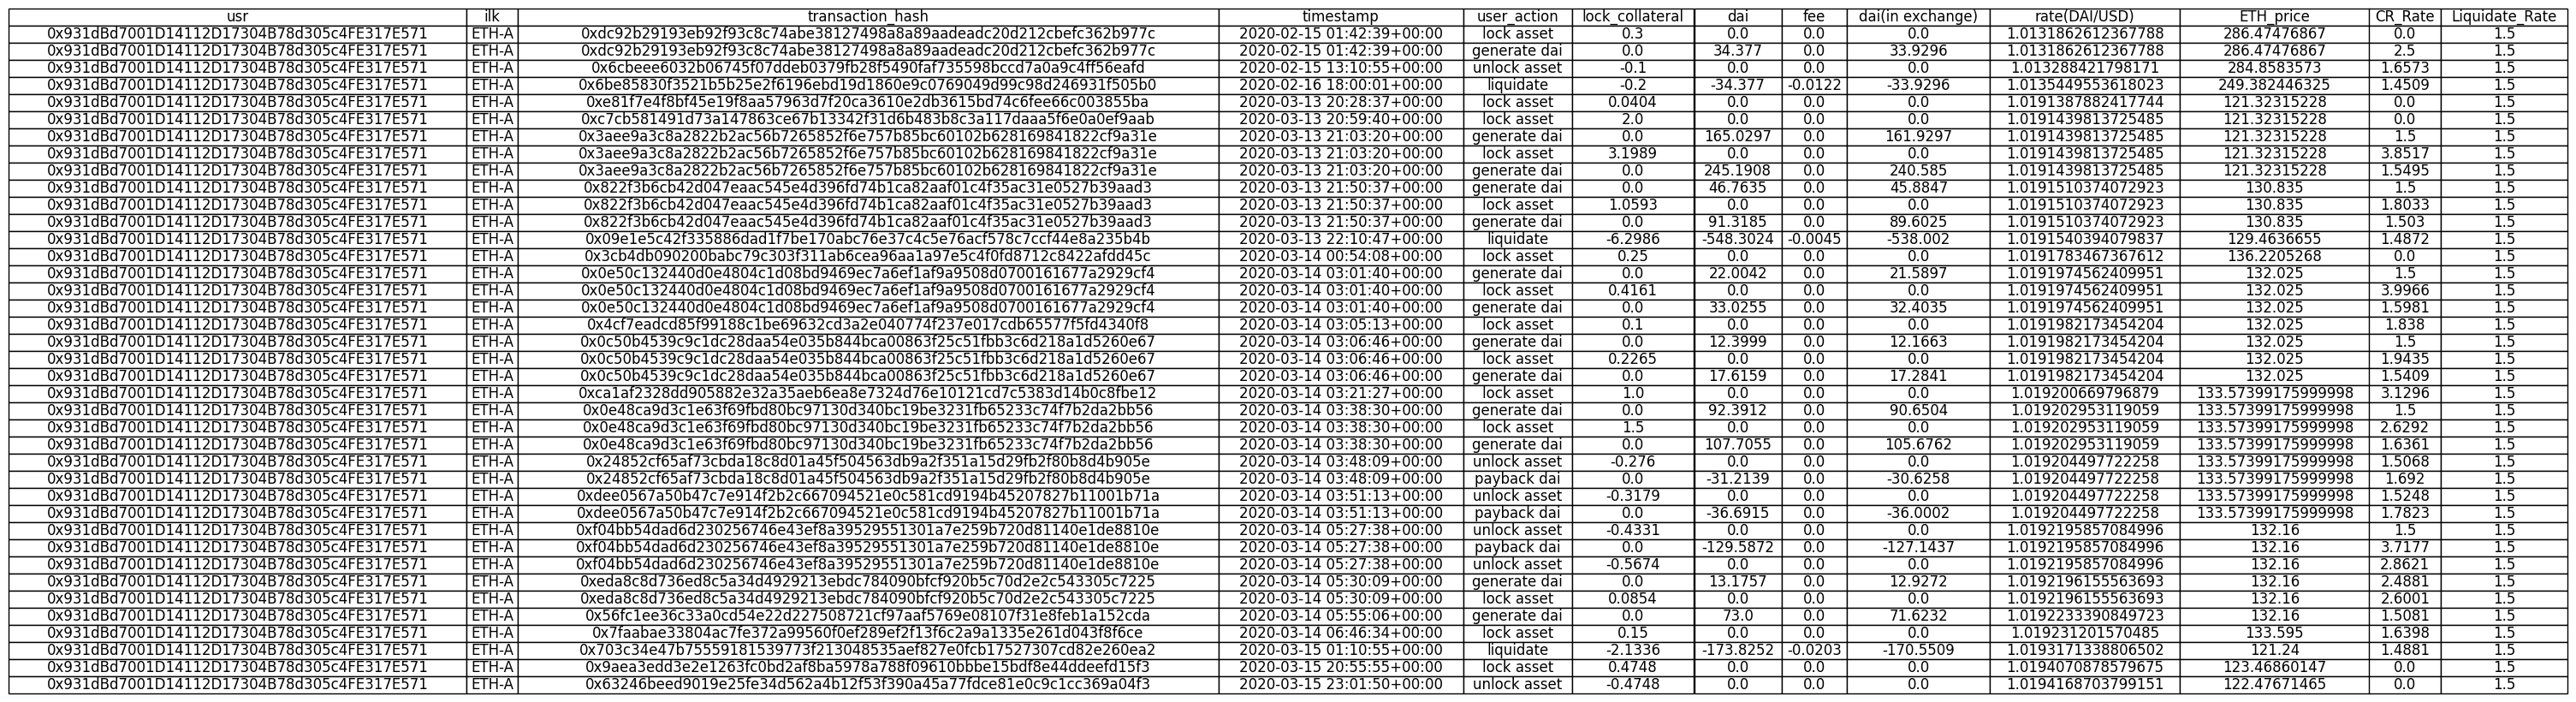

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  # Hide axis

# Create a table and display the DataFrame
table = plt.table(cellText=table_.values, colLabels=table_.columns ,loc='center', cellLoc='center') #cellText=table_.values
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust the table size if needed

# Extend column width for long text
table.auto_set_column_width(col=list(range(table_.shape[1])))

# plt.title('DataFrame as a Table')

# Save the figure as an image file
plt.savefig('tab1.png', bbox_inches='tight', pad_inches=0.5)

# Show the table
plt.show()

In [9]:
data_tab.to_csv('complete_eth_tab.csv')